# Multi-class classification of promotion description

This project aims to use Multi-class classification methods to classify promotion descriptions in grocery stores. The goal is to develop a model that can accurately categorize the promotions by their type, such as buy-one-get-one-free, discounts, and others. The aim is to classify future promotions data with the defined categories.

In [1]:
import math 
import random
import pandas as pd
import numpy as np
from collections import Counter

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from catboost import CatBoostClassifier

from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

#### Loading the data

In [2]:
# Import data about category description
category_description = pd.read_excel('promotion_id.xlsx')
# Create a new column that will contain an ordered sequence of integers
category_description['PromotionID_Ordered'] = np.arange(1,len(category_description)+1,1)-1
category_description.head()

,PromotionID,PromotionType,PromotionID_Ordered
0,10,מחיר מוזל,0
1,20,"Y גרם/קילו ב-X ש""ח",1
2,22,"2 יחידות ב-X ש""ח",2
3,23,"3 יחידות ב-X ש""ח",3
4,24,"4 יחידות ב-X ש""ח",4


In [3]:
# Import the data for each category
categories = ['pasta','yogurt','cheese','toothpaste','black_coffee','toilet_paper']

data = pd.read_excel('promotion_id.xlsx', sheet_name='rice')
for cat in categories:
    data = pd.concat([data,pd.read_excel('promotion_id.xlsx', sheet_name=cat)])
data

,PromotionDescription,PromotionID
0,מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.,10
1,2 קילו ב-22 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22
2,2 קילו ב-12 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22
3,2 קילו ב-25 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22
4,2 קילו ב-20 ₪. הרשת רשאית לשנות מבצעים בכל עת.,22
...,...,...
207,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30
208,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30
209,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30
210,"מחיר מוזל. מותנה ברכישה של 75.00 ש""ח ומעלה ממו...",30


#### Data preprocessing

In [4]:
data = data.drop_duplicates().reset_index(drop=True)
data['PromotionDescription'] = data['PromotionDescription'].astype('str')
# Merging the promotion description data with the category description data
data = pd.merge(data, category_description, on="PromotionID")
data

,PromotionDescription,PromotionID,PromotionType,PromotionID_Ordered
0,מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.,10,מחיר מוזל,0
1,"מחיר מוזל. מוגבל ל-3 מימושים / ק""ג בקניה אחת. ...",10,מחיר מוזל,0
2,"מחיר מוזל. מוגבל ל-1 מימושים / ק""ג בקניה אחת. ...",10,מחיר מוזל,0
3,"מחיר מוזל. מוגבל ל-2 מימושים / ק""ג בקניה אחת. ...",10,מחיר מוזל,0
4,"מחיר מוזל. מוגבל ל-4 מימושים / ק""ג בקניה אחת. ...",10,מחיר מוזל,0
...,...,...,...,...
1540,3 יחידות ב-20 ₪. הרשת רשאית לשנות מבצעים בכל עת.,23,"3 יחידות ב-X ש""ח",3
1541,3 יחידות ב-9.4 ₪. הרשת רשאית לשנות מבצעים בכל עת.,23,"3 יחידות ב-X ש""ח",3
1542,2 יחידות ב-25.6 ₪. הרשת רשאית לשנות מבצעים בכל...,23,"3 יחידות ב-X ש""ח",3
1543,6 יחידות ב-25 ₪. הרשת רשאית לשנות מבצעים בכל עת.,26,"6 יחידות ב-X ש""ח",6


### EDA

##### Taking a look at some promotion descriptions

In [5]:
pd.options.display.max_colwidth = 80
data['PromotionDescription'][0:5]

0                                       מחיר מוזל. הרשת רשאית לשנות מבצעים בכל עת.
1    מחיר מוזל. מוגבל ל-3 מימושים / ק"ג בקניה אחת. הרשת רשאית לשנות מבצעים בכל עת.
2    מחיר מוזל. מוגבל ל-1 מימושים / ק"ג בקניה אחת. הרשת רשאית לשנות מבצעים בכל עת.
3    מחיר מוזל. מוגבל ל-2 מימושים / ק"ג בקניה אחת. הרשת רשאית לשנות מבצעים בכל עת.
4    מחיר מוזל. מוגבל ל-4 מימושים / ק"ג בקניה אחת. הרשת רשאית לשנות מבצעים בכל עת.
Name: PromotionDescription, dtype: object

##### Category frequency

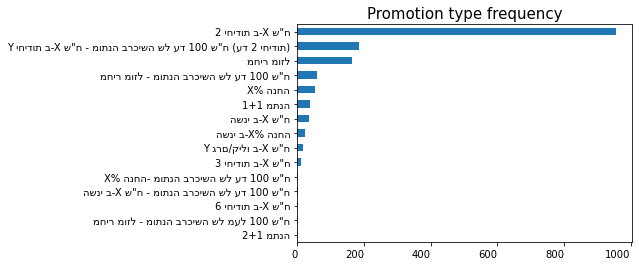

In [6]:
data['PromotionType'].value_counts()[:15].plot.barh().invert_yaxis()
plt.xticks(ha='right')
plt.title('Promotion type frequency',fontsize=15)
plt.show()

##### Length distribution of the promotion description

Text(0.5, 1.0, 'Text length distribution')

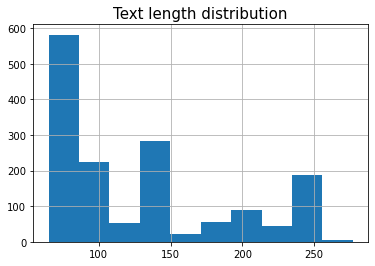

In [7]:
data['PromotionDescription'].str.split().map(lambda x: len(str(x))).hist()
plt.title('Text length distribution',fontsize=15)

The typical length of the promotion descriptions is short (below 100 characters)

Let's examine the 20 most frequent and least keywords/tokens in the data.

In [8]:
vectorizer_eda = CountVectorizer()
bow_ex = vectorizer_eda.fit_transform(data['PromotionDescription'])
print('The most frequent features:')
print(pd.DataFrame(bow_ex.toarray(),columns=vectorizer_eda.get_feature_names()).sum().sort_values(ascending=False).index[:20])
print('The least features:')
print(pd.DataFrame(bow_ex.toarray(),columns=vectorizer_eda.get_feature_names()).sum().sort_values(ascending=False).index[-20:])
print('All features:')
print(vectorizer_eda.get_feature_names())

The most frequent features:
Index(['הרשת', 'עת', 'בכל', 'רשאית', 'לשנות', 'מבצעים', 'יחידות', 'מוגבל',
       'בקניה', 'מימושים', 'אחת', 'עד', '2018', 'של', 'לא', 'ממוצרי', 'שבמבצע',
       'ברכישה', 'המוצרים', 'מותנה'],
      dtype='object')
The least features:
Index(['54', '72', '69', '56', '58', '65', '300', '68', '82', 'על', '76', '77',
       '83', '91', 'קנה', '93', '2020', '400', 'שלם', '250'],
      dtype='object')
All features:
['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '200', '2018', '2019', '2020', '21', '22', '23', '24', '25', '250', '26', '27', '28', '29', '30', '300', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '400', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '54', '55', '56', '58', '59', '60', '62', '63', '64', '65', '66', '68', '69', '70', '72', '74', '75', '76', '77', '78', '80', '82', '83', '84', '85', '90', '91', '93', '99', 'אחד', 

### Data preparation

In this project we will compare holdout validation to cross-validation. Since cross-validation can be more computationally intensive, and our data size is limited we will test the difference in accuracy. If the data size is limited, holdout validation can be more efficient than cross-validation in terms of data usage.

##### Create bag-of-word (BOW) matrix

We use BOW to convert text data into a numerical format that can be used as input for classification models. We use BOW here since it's simplicity and can handle new words that are not in the training set, by just adding them to the matrix without any modification and make it more generalizable.

#### Holdout validation data

In holdout validation, the BOW matrix should be created after splitting the data into training and test sets. If we create the BOW matrix before splitting the data, we will risk leakage of information from the test set into the training set. This can lead to overfitting, where the model performs well on the training set but not on new, unseen data.

Before splitting the data, we will duplicate entries with one instance. This is because in our case some classes have very few examples, which can make it difficult to ensure that the class is represented in the same proportion in the training and test sets as it is in the overall dataset.

In [9]:
# dulpicate entries with one instance to allow to stratify the train-test datasets
all_keys = data['PromotionID_Ordered'].unique().tolist()

t_df = pd.DataFrame()
c_df = pd.DataFrame()

for key in all_keys:
    if data.loc[data['PromotionID_Ordered']==key].shape[0] < 2 :
        t_df = t_df.append(data.loc[data['PromotionID_Ordered']==key])
        t_df = t_df.append(data.loc[data['PromotionID_Ordered']==key])
    else:
        c_df = c_df.append(data.loc[data['PromotionID_Ordered']==key])
        
data_dup = pd.concat([c_df,t_df]).reset_index()

# assign test data size 25%
X_train, X_test, y_train, y_test = train_test_split(data_dup['PromotionDescription'],data_dup['PromotionID_Ordered'],stratify=data_dup['PromotionID_Ordered'],test_size= 0.25, random_state=1)

# transform the train data into BOW
vectorizer_train = CountVectorizer()
x_vec_train = vectorizer_train.fit_transform(X_train)

# transform the test data into BOW
vectorizer_test = CountVectorizer(vocabulary= vectorizer_train.vocabulary_)
x_vec_test = vectorizer_test.transform(X_test)

# Present the BOW matrix of training data
pd.DataFrame(x_vec_train.toarray(),columns=vectorizer_train.get_feature_names())

,00,01,02,03,04,05,06,07,08,09,...,פלוס,פריט,קופון,קילו,קנה,רשאית,שבמבצע,של,שלם,תיתכנה
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1156,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1157,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,1,0,1
1158,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1159,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Since our data is unbalanced we will oversample the minority classes in the training data. Class imbalance occurs when one class has significantly more examples than another class. This can make it difficult for a classifier to correctly identify examples of the minority class, leading to poor accuracy.

In [10]:
over_dict = dict(Counter(y_train))

#### over sampling just for the training data
for key in over_dict:
    # increase the minority classes by 80%
    if over_dict[key] < max(y_train.value_counts()):
        over_dict[key] = min(over_dict[key]*1.8, max(y_train.value_counts()))
    # if still lower than 50% from the maximum, increase the number to 50%
    if over_dict[key] < round(max(y_train.value_counts())*0.6):
        over_dict[key] = round(max(y_train.value_counts())*0.6)

# instantiating over sampler
over = RandomOverSampler(sampling_strategy=over_dict)

# perform oversampling to minority class
X_over, y_over = over.fit_resample(x_vec_train, y_train)

x_vec_train, y_train = X_over, y_over

#### Cross validation data

In cross-validation, the process of creating the BOW matrix and splitting the data into training and test sets is done within each fold. This ensures that the words and their frequencies are based only on the training set within each fold, and that the test set is independent and unseen. This will help us to avoid overfitting.

In [11]:
X, y = data['PromotionDescription'],data['PromotionID_Ordered']

# Define the number of folds
n_folds = 5

We will track the model performance with accuracy since we are intersted in the overall accuracy and not just to minimize false negatives or false positives.

In [12]:
# track model performance
holdout_validation_log_models = pd.DataFrame(columns=["Classifier", "Accuracy","Balanced Accuracy"])
cross_validation_log_models = pd.DataFrame(columns=["Classifier", "Accuracy","Balanced Accuracy"])

## Naive Bayes classifier

Naive Bayes classifier is based on the Bayes theorem, making it easy to understand.

#### With holdout validation data

In [13]:
# Call the model
mnb = MultinomialNB()

# Train the model
mnb.fit(x_vec_train, y_train)

# Prediction accuracy of the train data
y_pred_train = mnb.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# Prediction accuracy of the test data
y_pred_test = mnb.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

holdout_validation_log_models.loc[len(holdout_validation_log_models)] = ['Naive Bayes',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

Accuracy of train data:  0.9352588251709223
Accuracy of test data:  0.7525773195876289


#### With cross validation data

In [14]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = MultinomialNB()

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Use cross validation to train the classifier
cv_scores = cross_val_score(pipe, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)
y_pred = cross_val_predict(pipe, X, y, cv=n_folds, n_jobs=-1, verbose=1)

print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')

cross_validation_log_models.loc[len(cross_validation_log_models)] = ['Naive Bayes',accuracy_score(y, y_pred),balanced_accuracy_score(y, y_pred)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s


Mean accuracy:  64.725 % std:  10.641 %


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished


## Logistic regression

#### With holdout validation data

In [15]:
# Call the model
logr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Train the model
logr.fit(x_vec_train, y_train)

# Prediction accuracy of the train data
y_pred_train = logr.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# Prediction accuracy of the test data
y_pred_test = logr.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

holdout_validation_log_models.loc[len(holdout_validation_log_models)] = ['Logistic regression',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

Accuracy of train data:  0.9836751778987024
Accuracy of test data:  0.9587628865979382


#### With cross validation data

In [16]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Use cross validation to train the classifier
cv_scores = cross_val_score(pipe, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)
y_pred = cross_val_predict(pipe, X, y, cv=n_folds, n_jobs=-1, verbose=1)

print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')

cross_validation_log_models.loc[len(cross_validation_log_models)] = ['Logistic regression',accuracy_score(y, y_pred),balanced_accuracy_score(y, y_pred)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Mean accuracy:  86.084 % std:  10.248 %


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.5s finished


## Random forest

#### With holdout validation data

In [17]:
# Call the model
rfc = RandomForestClassifier(bootstrap=True,
                              max_depth=12,
                              max_features='sqrt',
                              random_state=1)

# Train the model
rfc.fit(x_vec_train, y_train)

# Prediction accuracy of the train data
y_pred_train = rfc.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# Prediction accuracy of the test data
y_pred_test = rfc.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

holdout_validation_log_models.loc[len(holdout_validation_log_models)] = ['Random forest',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

Accuracy of train data:  0.9799079112599414
Accuracy of test data:  0.9278350515463918


#### With cross validation data

In [18]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = RandomForestClassifier(bootstrap=True,
                              max_depth=12,
                              max_features='sqrt',
                              random_state=1)

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Use cross validation to train the classifier
cv_scores = cross_val_score(pipe, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)
y_pred = cross_val_predict(pipe, X, y, cv=n_folds, n_jobs=-1, verbose=1)

print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')

cross_validation_log_models.loc[len(cross_validation_log_models)] = ['Random forest',accuracy_score(y, y_pred),balanced_accuracy_score(y, y_pred)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Mean accuracy:  78.188 % std:  10.514 %


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished


## AdaBoost

#### With holdout validation data

In [19]:
# Call the model
dtc = DecisionTreeClassifier(max_depth=8)
abt = AdaBoostClassifier(dtc, n_estimators=300, learning_rate=1)

# Train the model
abt.fit(x_vec_train, y_train)

# Prediction accuracy of the train data
y_pred_train = abt.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# Prediction accuracy of the test data
y_pred_test = abt.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

holdout_validation_log_models.loc[len(holdout_validation_log_models)] = ['AdaBoost',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

Accuracy of train data:  0.9912097111762244
Accuracy of test data:  0.9278350515463918


#### With cross validation data

In [20]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
dtc = DecisionTreeClassifier(max_depth=8)
clf = AdaBoostClassifier(dtc, n_estimators=300, learning_rate=1)

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Use cross validation to train the classifier
cv_scores = cross_val_score(pipe, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)
y_pred = cross_val_predict(pipe, X, y, cv=n_folds, n_jobs=-1, verbose=1)

print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')

cross_validation_log_models.loc[len(cross_validation_log_models)] = ['AdaBoost',accuracy_score(y, y_pred),balanced_accuracy_score(y, y_pred)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.7s remaining:   29.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.1s remaining:   28.8s


Mean accuracy:  92.557 % std:  4.279 %


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.2s finished


### CatBoost

We use CatBoost since it can handle categorical features directly with the "Ordered Boosting", instead of encoding them as numerical values, which can lead to better results.

#### With holdout validation data

In [21]:
# Call the model
cbt = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    verbose=False
)

# Train the model
cbt.fit(x_vec_train, y_train)

# Prediction accuracy of the train data
y_pred_train = cbt.predict(x_vec_train)
print('Accuracy of train data: ',accuracy_score(y_pred_train, y_train))

# Prediction accuracy of the test data
y_pred_test = cbt.predict(x_vec_test)
print('Accuracy of test data: ',accuracy_score(y_test, y_pred_test))

holdout_validation_log_models.loc[len(holdout_validation_log_models)] = ['CatBoost',accuracy_score(y_test, y_pred_test),balanced_accuracy_score(y_test, y_pred_test)]

Accuracy of train data:  0.9189340030696247
Accuracy of test data:  0.9768041237113402


#### With cross validation data

In [22]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = CatBoostClassifier(
    iterations=10, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
    verbose=False
)

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])
y_pred = cross_val_predict(pipe, X, y, cv=n_folds, n_jobs=-1, verbose=1)

# Use cross validation to train the classifier
cv_scores = cross_val_score(pipe, X, y, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)

print('Mean accuracy: ', round(cv_scores.mean()*100, 3), '% std: ', round(math.sqrt(cv_scores.var())*100, 3),'%')

cross_validation_log_models.loc[len(cross_validation_log_models)] = ['CatBoost',accuracy_score(y, y_pred),balanced_accuracy_score(y, y_pred)]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.8s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s


Mean accuracy:  59.482 % std:  25.874 %


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.6s finished


### Classification accuracy by each model

#### With holdout validation data

In [23]:
holdout_validation_log_models = holdout_validation_log_models.set_index('Classifier')
holdout_validation_log_models

,Accuracy,Balanced Accuracy
Classifier,,
Naive Bayes,0.752577,0.853538
Logistic regression,0.958763,0.912134
Random forest,0.927835,0.906266
AdaBoost,0.927835,0.796201
CatBoost,0.976804,0.898605


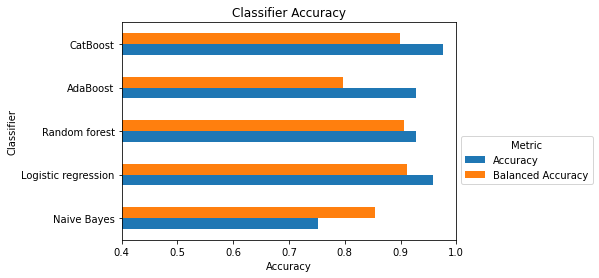

In [24]:
holdout_validation_log_models.plot.barh()
plt.title('Classifier Accuracy')
plt.legend(title='Metric', bbox_to_anchor=(1, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.4,1))
plt.show()

#### With cross validation data

In [25]:
cross_validation_log_models = cross_validation_log_models.set_index('Classifier')
cross_validation_log_models

,Accuracy,Balanced Accuracy
Classifier,,
Naive Bayes,0.636246,0.598967
Logistic regression,0.869256,0.630535
Random forest,0.789644,0.633826
AdaBoost,0.927508,0.600157
CatBoost,0.592880,0.663291


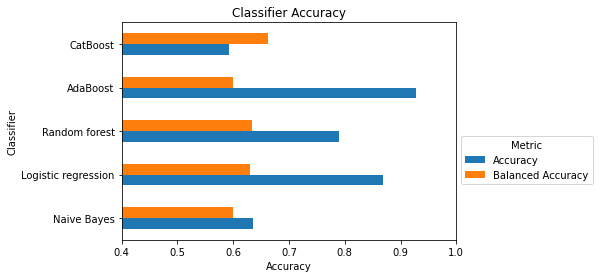

In [26]:
cross_validation_log_models.plot.barh()
plt.title('Classifier Accuracy')
plt.legend(title='Metric', bbox_to_anchor=(1, 0.5))
plt.xlabel('Accuracy')
plt.xlim((0.4,1))
plt.show()

We see in a big difference between the accuracy score to the balanced accuracy score for holdout validation method and the cross validation method. 

##### Accuracy comparison between holdout and cross validation data

In [27]:
Accuracy_df = pd.concat([holdout_validation_log_models['Balanced Accuracy'],cross_validation_log_models['Balanced Accuracy']], axis=1)
Accuracy_df.columns = ['Holdout validation','Cross validation']
Accuracy_df

,Holdout validation,Cross validation
Classifier,,
Naive Bayes,0.853538,0.598967
Logistic regression,0.912134,0.630535
Random forest,0.906266,0.633826
AdaBoost,0.796201,0.600157
CatBoost,0.898605,0.663291


We also see in a big difference the accuracy of the holdout validation method and the cross validation method. It could mean that the model is overfitting in the holdout validation method. It indicates that the training dataset is not representative of the population. Therefore, we will choose the cross validation method in our case. 

The model with the best accuracy in the cross validation method:

In [28]:
cross_validation_log_models.index[cross_validation_log_models['Balanced Accuracy']==max(cross_validation_log_models['Balanced Accuracy'])]

Index(['CatBoost'], dtype='object', name='Classifier')

One possible reason why CatBoost got better accuracy than the other models is that it was able to make better use of the categorical features in our data. Additionally, CatBoost also uses a built-in regularization mechanism that can prevent overfitting, which can also lead to better results.

### Hyperparameter tuning with grid search and random search - cross validation

Since the best model here is the CatBoost model, but the aacuracy is still low in industry standard, we will use grid and random search to find the optimal hyperparameters. Thus, we will check which method find the optimal model. Also, grid search may lead to overfitting, as it tries to optimize the model on the specific data it was trained on. Random search may help to mitigate this issue by sampling a random subset of the parameter space.

#### Grid search

In [29]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = CatBoostClassifier(verbose=False)

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Define the parameters to be searched
param_grid = {'clf__iterations': [10, 20, 30],
              'clf__learning_rate': list(np.linspace(0.01, 0.1, 10)),
              'clf__depth': list(np.linspace(3, 10, 8))}

# Create an instance of the grid search
grid = GridSearchCV(pipe, param_grid, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid.fit(X, y)

# Print the best parameters
print('Best parameters: ', grid.best_params_)

# Print the best score
print('Best score: ', grid.best_score_)

# Predict the target variable using the best estimator
y_pred = grid.predict(X)

# Print the accuracy and balanced accuracy scores
print('Accuracy score: ', accuracy_score(y, y_pred))
print('Balanced accuracy score: ', balanced_accuracy_score(y, y_pred))

# plot in table the result of random search
grid_search_results = pd.DataFrame(grid.cv_results_)
grid_search_results

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Best parameters:  {'clf__depth': 9.0, 'clf__iterations': 30, 'clf__learning_rate': 0.09000000000000001}
Best score:  0.8142394822006473
Accuracy score:  0.9488673139158577
Balanced accuracy score:  0.9797922701426885


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__depth,param_clf__iterations,param_clf__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.965130,0.044109,0.023338,0.005555,3.0,10,0.01,"{'clf__depth': 3.0, 'clf__iterations': 10, 'clf__learning_rate': 0.01}",0.343042,0.349515,0.378641,0.349515,0.343042,0.352751,0.013265,238
1,1.030744,0.066412,0.024136,0.007340,3.0,10,0.02,"{'clf__depth': 3.0, 'clf__iterations': 10, 'clf__learning_rate': 0.020000000...",0.355987,0.355987,0.378641,0.349515,0.365696,0.361165,0.010152,236
2,1.072233,0.068451,0.018949,0.000892,3.0,10,0.03,"{'clf__depth': 3.0, 'clf__iterations': 10, 'clf__learning_rate': 0.030000000...",0.349515,0.349515,0.372168,0.349515,0.401294,0.364401,0.020427,234
3,1.009500,0.064645,0.021543,0.001352,3.0,10,0.04,"{'clf__depth': 3.0, 'clf__iterations': 10, 'clf__learning_rate': 0.040000000...",0.355987,0.355987,0.378641,0.349515,0.404531,0.368932,0.020365,229
4,1.044009,0.034210,0.024933,0.004324,3.0,10,0.05,"{'clf__depth': 3.0, 'clf__iterations': 10, 'clf__learning_rate': 0.050000000...",0.349515,0.944984,0.378641,0.349515,0.404531,0.485437,0.230688,176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,58.927104,2.592096,0.024398,0.007874,10.0,30,0.06,"{'clf__depth': 10.0, 'clf__iterations': 30, 'clf__learning_rate': 0.06000000...",0.320388,0.588997,0.796117,0.906149,0.818770,0.686084,0.210381,15
236,57.604517,3.118738,0.026329,0.006533,10.0,30,0.07,"{'clf__depth': 10.0, 'clf__iterations': 30, 'clf__learning_rate': 0.07}",0.320388,0.621359,0.957929,0.906149,0.844660,0.730097,0.234824,10
237,58.477535,2.893861,0.049987,0.046757,10.0,30,0.08,"{'clf__depth': 10.0, 'clf__iterations': 30, 'clf__learning_rate': 0.08}",0.330097,0.666667,0.951456,0.902913,0.922330,0.754693,0.235294,8
238,61.797379,3.003733,0.057436,0.050242,10.0,30,0.09,"{'clf__depth': 10.0, 'clf__iterations': 30, 'clf__learning_rate': 0.09000000...",0.320388,0.695793,0.961165,0.983819,0.928803,0.777994,0.250926,6


#### Random search

In [30]:
# transform the train data into BOW
vectorizer = CountVectorizer()

# Define the classifier
clf = CatBoostClassifier(verbose=False)

# Create an instance of the oversampler
oversampler = RandomOverSampler()

# Create a pipeline that applies the vectorizer, oversampler and the classifier
pipe = Pipeline([('vec',vectorizer), ('over',oversampler), ('clf',clf)])

# Define the parameters to be searched
param_random = {'clf__iterations': randint(10, 40),
              'clf__learning_rate': uniform(0.01, 0.2),
              'clf__depth': randint(3,12)}

# Create an instance of the grid search
random = RandomizedSearchCV(pipe, param_grid, cv=n_folds, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit the grid search to the data
random.fit(X, y)

# Print the best parameters
print('Best parameters: ', random.best_params_)

# Print the best score
print('Best score: ', random.best_score_)

# Predict the target variable using the best estimator
y_pred = random.predict(X)

# Print the accuracy and balanced accuracy scores
print('Accuracy score: ', accuracy_score(y, y_pred))
print('Balanced accuracy score: ', balanced_accuracy_score(y, y_pred))

# plot in table the result of random search
random_search_results = pd.DataFrame(random.cv_results_)
random_search_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters:  {'clf__learning_rate': 0.09000000000000001, 'clf__iterations': 20, 'clf__depth': 9.0}
Best score:  0.6951456310679612
Accuracy score:  0.8614886731391586
Balanced accuracy score:  0.9647818098916425


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate,param_clf__iterations,param_clf__depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.937856,0.219522,0.041197,0.017042,0.01,10,7.0,"{'clf__learning_rate': 0.01, 'clf__iterations': 10, 'clf__depth': 7.0}",0.223301,0.375405,0.970874,0.721683,0.401294,0.538511,0.270288,5
1,3.631288,0.341092,0.022605,0.005919,0.09,20,4.0,"{'clf__learning_rate': 0.09000000000000001, 'clf__iterations': 20, 'clf__dep...",0.378641,0.375405,0.679612,0.721683,0.404531,0.511974,0.154954,6
2,4.036353,0.168824,0.024993,0.007652,0.1,30,3.0,"{'clf__learning_rate': 0.1, 'clf__iterations': 30, 'clf__depth': 3.0}",0.362460,0.394822,0.378641,0.721683,0.404531,0.452427,0.135388,8
3,4.368879,0.668701,0.024993,0.007651,0.03,20,5.0,"{'clf__learning_rate': 0.030000000000000006, 'clf__iterations': 20, 'clf__de...",0.355987,0.375405,0.970874,0.721683,0.401294,0.565049,0.243193,2
4,9.858575,0.390989,0.009371,0.012496,0.02,10,9.0,"{'clf__learning_rate': 0.020000000000000004, 'clf__iterations': 10, 'clf__de...",0.229773,0.401294,0.860841,0.883495,0.404531,0.555987,0.265888,3
5,2.786768,0.242243,0.040618,0.035067,0.02,10,4.0,"{'clf__learning_rate': 0.020000000000000004, 'clf__iterations': 10, 'clf__de...",0.355987,0.349515,0.372168,0.349515,0.627832,0.411003,0.108730,9
6,19.260961,1.130899,0.029067,0.011644,0.09,20,9.0,"{'clf__learning_rate': 0.09000000000000001, 'clf__iterations': 20, 'clf__dep...",0.440129,0.592233,0.883495,0.786408,0.773463,0.695146,0.158469,1
7,8.888204,0.543647,0.054981,0.019917,0.01,30,5.0,"{'clf__learning_rate': 0.01, 'clf__iterations': 30, 'clf__depth': 5.0}",0.355987,0.375405,0.378641,0.349515,0.401294,0.372168,0.018307,10
8,38.420834,1.496376,0.024991,0.007655,0.02,30,10.0,"{'clf__learning_rate': 0.020000000000000004, 'clf__iterations': 30, 'clf__de...",0.252427,0.401294,0.718447,0.770227,0.627832,0.554045,0.196730,4
9,10.442834,0.741810,0.055317,0.045744,0.01,20,6.0,"{'clf__learning_rate': 0.01, 'clf__iterations': 20, 'clf__depth': 6.0}",0.229773,0.375405,0.378641,0.880259,0.404531,0.453722,0.221936,7


We see that tuning the hyperparameters improve significantly the accuracy and in the level of industry standard. Thus, we will take the best model we succeed to find. That is from the grid search.

We will plot the results of the hyperparameter tuning that will help us to understand the behavior of the hyperparameters. 

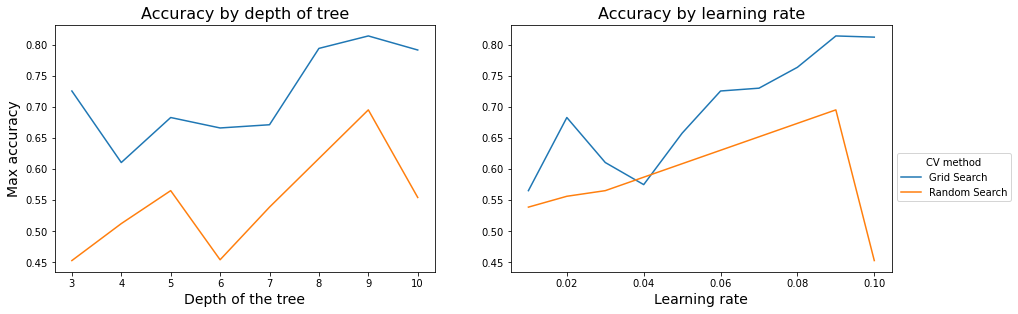

In [36]:
# plot hyperparameter tuning process
plt.figure(figsize=(15,10))

plt.subplot(2,2,1)
# plot hyperparameter tuning process of tree depth
grid_search_results.groupby('param_clf__depth')['mean_test_score'].max().plot(label='Grid Search')
random_search_results.groupby('param_clf__depth')['mean_test_score'].max().plot(label='Random Search')

#plt.legend(title='CV method')

plt.ylabel('Max accuracy', fontsize=14)
plt.xlabel('Depth of the tree', fontsize=14)
plt.title('Accuracy by depth of tree', fontsize=16)

plt.subplot(2,2,2)
# plot hyperparameter tuning process of learning rate
grid_search_results.groupby('param_clf__learning_rate')['mean_test_score'].max().plot(label='Grid Search', ax=plt.gca())
random_search_results.groupby('param_clf__learning_rate')['mean_test_score'].max().plot(label='Random Search', ax=plt.gca())
plt.legend(title='CV method', bbox_to_anchor=(1, 0.5))

#plt.ylabel('Max accuracy', fontsize=14)
plt.xlabel('Learning rate', fontsize=14)
plt.title('Accuracy by learning rate', fontsize=16)

plt.show()

We see that the grid search perform much better than random search, probably since grid search use better combinations of hyperparameters but also since it checked much more combinations.